In this kernel we will go through a sentiment analysis on imdb dataset using LSTM.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g51d5qBJPzL1yAZDAJkLrS4tZyDmBvwEaGY3AA8J3myHLstKNyx74A


In [7]:
positive_csv='/content/drive/MyDrive/4th_Sem/IR/Project/features_positive.csv'
df=pd.read_csv(positive_csv)
l=df['tweet'].values
output=['positive']*len(l)
negative_csv='/content/drive/MyDrive/4th_Sem/IR/Project/features_negative.csv'
df=pd.read_csv(negative_csv)
l1=df['tweet'].values
output1=['negative']*len(l1)
l=np.append(l,l1)
output=np.append(output,output1)
list_of_tuples = list(zip(l, output)) 
list_of_tuples    
df = pd.DataFrame(list_of_tuples,
                  columns = ['review', 'sentiment']) 
df=df.sample(n = 1000)


In [9]:
df.head()

,review,sentiment
903,krhtrillion logo_a_day rt artfx...,negative
317,i be unemployed i have be diagnose with ptsd ...,positive
728,i have such a crazy dream last night if you d...,negative
557,i should be at wanderer right now yazi savsl ...,negative
465,you seem depress lately why be that ive be di...,positive


### Splitting to train and test data

We will split data to train and test initially.Doing this on earlier stage allows to avoid data lekage.


In [10]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (750,)
shape of test data is (250,)


### Analysing sentiment

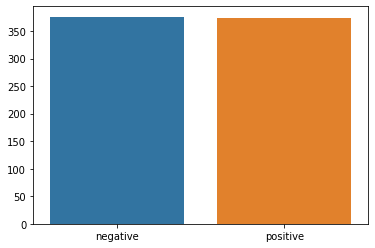

In [11]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tockenization

In [12]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [13]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [14]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

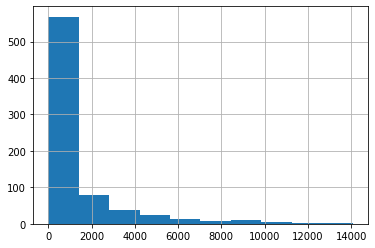

count      750.000000
mean      1328.410667
std       2165.199768
min          0.000000
25%        156.000000
50%        480.000000
75%       1340.500000
max      14071.000000
dtype: float64

In [15]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

Now we will pad each of the sequence to max length 

In [16]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [17]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,1500)
x_test_pad = padding_(x_test,1500)


### Batching and loading as tensor

In [18]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [19]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 1500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   6,  26, 283],
        [  0,   0,   0,  ...,   6,  69, 395],
        [  1, 546,  26,  ...,   7,  21, 439],
        ...,
        [  0,   0,   0,  ...,  70,   1,  97],
        [  0,   0,   0,  ..., 197, 579, 458],
        [  0,   0,   0,  ..., 112,  34,  38]])
Sample input: 
 tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

In [20]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        self.dropout = nn.Dropout(0.8)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x) 
        lstm_out, hidden = self.lstm(embeds, hidden)        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        out = self.dropout(lstm_out)
        out = self.fc(out)        
        sig_out = self.sig(out)        
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] 
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [127]:
no_layers = 3
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 512
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 512, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Training

In [21]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [128]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [129]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.6835545500119528 val_loss : 0.6281878709793091
train_accuracy : 54.400000000000006 val_accuracy : 58.4
Validation loss decreased (inf --> 0.628188).  Saving model ...
Epoch 2
train_loss : 0.6597593824068705 val_loss : 0.6300765752792359
train_accuracy : 62.53333333333333 val_accuracy : 62.8
Epoch 3
train_loss : 0.579094523191452 val_loss : 0.6172662019729614
train_accuracy : 70.0 val_accuracy : 64.8
Validation loss decreased (0.628188 --> 0.617266).  Saving model ...
Epoch 4
train_loss : 0.5510916392008464 val_loss : 0.6193891644477845
train_accuracy : 73.6 val_accuracy : 64.0
Epoch 5
train_loss : 0.49561970035235087 val_loss : 0.633677875995636
train_accuracy : 77.86666666666666 val_accuracy : 64.4
Epoch 6
train_loss : 0.41563453872998557 val_loss : 0.7204426169395447
train_accuracy : 81.2 val_accuracy : 64.4
Epoch 7
train_loss : 0.35776052077611287 val_loss : 0.702371621131897
train_accuracy : 85.2 val_accuracy : 63.6
Epoch 8
train_loss : 0.28418742020924886 va

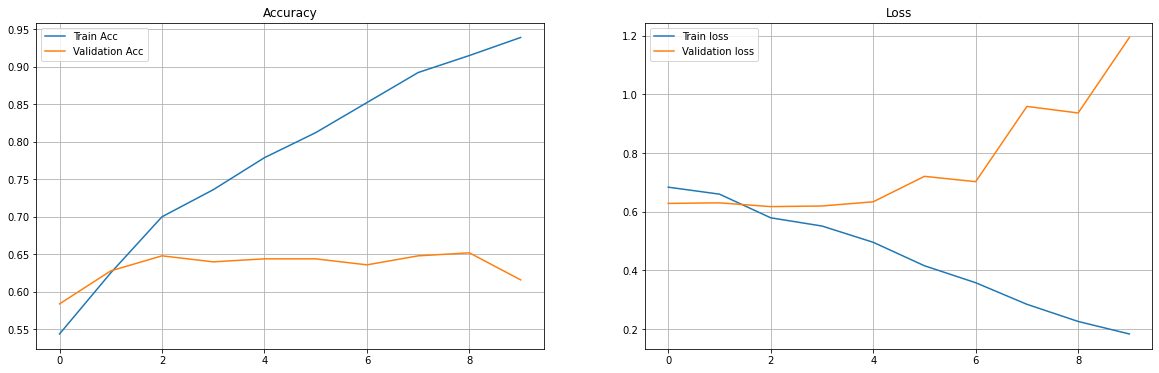

In [130]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

#Atttention Model

In [22]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim
        
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight).view(-1, step_dim)

        if self.bias:
            eij = eij + self.b           
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None:
            a = a * mask
        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)       
        weighted_input = x * torch.unsqueeze(a.T, -1)
        
        return torch.sum(weighted_input, 1)


In [23]:
class Atten_net(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(Atten_net, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,num_layers=no_layers, batch_first=True)
        self.attention = Attention(256,50)
        
        self.dropout = nn.Dropout(0.5)    
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, X,hidden):

        batch_size = X.size(0)
        h1_embedding = self.embedding(X)
        h1_embedding = torch.squeeze(torch.unsqueeze(h1_embedding, 0))

        out, _ = self.lstm(h1_embedding)
        
        out=self.attention(out)
        
        
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [24]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model = Atten_net(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

Atten_net(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (attention): Attention()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [25]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [26]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.7334569811820983 val_loss : 0.7354124426841736
train_accuracy : 59.199999999999996 val_accuracy : 50.0
Validation loss decreased (inf --> 0.735412).  Saving model ...
Epoch 2
train_loss : 0.664478067557017 val_loss : 0.648106849193573
train_accuracy : 58.8 val_accuracy : 62.0
Validation loss decreased (0.735412 --> 0.648107).  Saving model ...
Epoch 3
train_loss : 0.6304716308911641 val_loss : 0.6035121798515319
train_accuracy : 66.4 val_accuracy : 66.4
Validation loss decreased (0.648107 --> 0.603512).  Saving model ...
Epoch 4
train_loss : 0.6897599200407664 val_loss : 0.5823210597038269
train_accuracy : 69.73333333333333 val_accuracy : 68.8
Validation loss decreased (0.603512 --> 0.582321).  Saving model ...
Epoch 5
train_loss : 0.5250455697377523 val_loss : 0.546500438451767
train_accuracy : 72.53333333333333 val_accuracy : 74.4
Validation loss decreased (0.582321 --> 0.546500).  Saving model ...
Epoch 6
train_loss : 0.46386802991231285 val_loss : 0.637953603

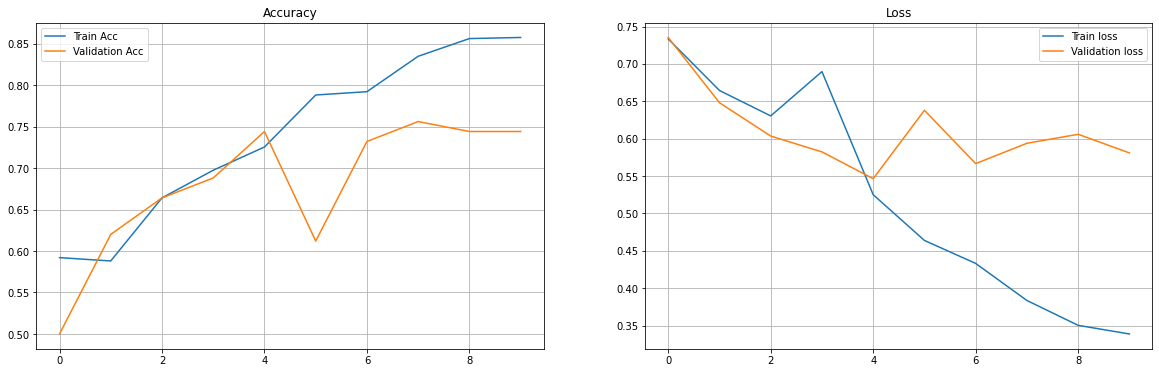

In [27]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

# Sequence Model

### Inferance

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [ ]:

index = 265
print(df['review'][index])

print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

 i can relate to sail cuz when i be a kid i be diagnose with add bipolar disorder and depression and that be why i toke i be go to mention sail dub step another good one thanks for that shout out e3unite yup that too  pokérigs towelie mini rig oklahoma house vote 98 to 2 to allow use of cannabis extract for epilepsy false the only thing that suck about weed be when you dont have any you know what suck about weed absolutely nothing it all good dont fear the reefer stonernation stonerfamily i just have tunein glitch crazy the show and music be speed up and sound like chipmunk talk i fix it tho the sweet leaf remix a need a blunt in them tho reddlr tree do it again 300g slab of shatter that song playing now be bomb a fuck tho love it didnt get as many a i want to but have quite a few for today show edm dub plur tuneintokeup ive sat here smoke 2 joint and a couple bong hit feel a bit well love that song weedcrushwednesday wcw i definitely read to that to beat of marble floor by rick ross g

Some improvement suggestions are as follow:

* Running a hyperparameter search to optimize your configurations.
* Using pretraned word embeddings like Glove word embeddings
* Increasing the model complexity like adding more layers/ using bidirectional LSTMs
